# 0.0 Opening

## 0.1 Imports

In [80]:
import pickle

import numpy                  as np
import pandas                 as pd
import seaborn                as sns

from scipy      import stats
from xgboost    import XGBClassifier
from matplotlib import pyplot as plt

from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.preprocessing     import RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.dummy             import DummyClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.ensemble          import RandomForestClassifier
from sklearn.model_selection   import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics           import accuracy_score, make_scorer, f1_score, precision_score, recall_score

## 0.2 Helper Functions

In [2]:
np.random.seed(42)

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [4]:
accuracy = make_scorer(accuracy_score)
precision = make_scorer(lambda y_true, y_pred: precision_score(y_true, y_pred, average="macro"))
recall = make_scorer(lambda y_true, y_pred: recall_score(y_true, y_pred, average="macro"))
f1 = make_scorer(lambda y_true, y_pred: f1_score(y_true, y_pred, average="macro"))

In [5]:
def ml_scores(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return pd.DataFrame({'Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3)}, index=[model_name])

In [6]:
def ml_cv_results(model_name, model, rescaler, X, y):

    X_ = X.to_numpy()
    y_ = y.to_numpy()

    mm = rescaler
    
    accuracies = []
    precisions = []
    recalls = []
    f1s = []

    '''for for cross validation'''
    kf = KFold(n_splits=5, shuffle=True)
    for train, test in kf.split(X_):
       
        X_train, X_test = X_[train], X_[test]
        y_train, y_test = y_[train], y_[test]

        X_train_rescaled = mm.fit_transform(X_train)
        X_test_rescaled = mm.fit_transform(X_test)
        
        model.fit(X_train_rescaled, y_train)
        y_pred = model.predict(X_test_rescaled)

        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average="macro"))
        recalls.append(recall_score(y_test, y_pred, average="macro"))
        f1s.append(f1_score(y_test, y_pred, average="macro"))
        
    accuracy_mean, accuracy_std = np.round(np.mean(accuracies), 3), np.round(np.std(accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    
    return pd.DataFrame({"Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +- {}".format(precision_mean, precision_std),
                        "Recall": "{} +- {}".format(recall_mean, recall_std),
                        "F1": "{} +- {}".format(f1_mean, f1_std)},
                       index=[model_name])

In [7]:
def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

Based on [The 12 Stages of Life](https://www.institute4learning.com/resources/articles/the-12-stages-of-life/), I'll create a function to identify each stage of the life. It will help in data analysis step.

In [8]:
def getLifeStage(age):
    if age <= 3:
        life_stage = "Infancy"
    
    elif age > 3 and age <= 6:
        life_stage = "Early Childhood"
        
    elif age > 6 and age <= 8:
        life_stage = "Middle Childhood"
        
    elif age >= 9 and age <= 11:
        lige_stage = "Late Childhood"
        
    elif age >= 12 and age <= 20:
        life_stage = "Adolescence"
        
    elif age > 20 and age <= 35:
        life_stage = "Early Adulthood"
        
    elif age > 35 and age <= 50:
        life_stage = "Midlife"
        
    elif age > 50 and age <= 80:
        life_stage = "Mature Adulthood"
        
    else:
        life_stage = "Late Adulthood"
        
    return life_stage

Based on [Measuring BMI for adults, children, and teens](https://www.medicalnewstoday.com/articles/323622#Understanding-the-results), I'll calculate the BMI and determine if there's any overwigth or not. 

In [9]:
def calcIBM(weight, height):
    #BMI = kg/m2
    ibm = np.round(weight / (height**2), 1)
    
    return ibm

def catIBM(ibm):
    if ibm < 18.5:
        status = "Underweight"
    
    elif ibm >= 18.5 and ibm <= 24.9:
        status = "Healthy"
    
    elif ibm >= 25.0 and ibm <= 29.9:
        status = "Overweight"
        
    elif ibm >= 30.0:
        status = "Obese"
        
    return status

## 0.3 Loading Data

In [11]:
df_raw = pd.read_csv("../database/cardio.csv", sep=";", low_memory=False)
df_raw.head()

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  cardio
0   0  18393       2     168    62.0    110     80            1     1      0     0       1       0
1   1  20228       1     156    85.0    140     90            3     1      0     0       1       1
2   2  18857       1     165    64.0    130     70            3     1      0     0       0       1
3   3  17623       2     169    82.0    150    100            1     1      0     0       1       1
4   4  17474       1     156    56.0    100     60            1     1      0     0       0       0

# 1.0 Data Description

In [12]:
df1 = df_raw.copy()

Data description

There are 3 types of input features:

    Objective: factual information;
    Examination: results of medical examination;
    Subjective: information given by the patient.

Features:

1. Age | Objective Feature | age | int (days)
1. Height | Objective Feature | height | int (cm) |
1. Weight | Objective Feature | weight | float (kg) |
1. Gender | Objective Feature | gender | categorical code |
1. Systolic blood pressure | Examination Feature | ap_hi | int |
1. Diastolic blood pressure | Examination Feature | ap_lo | int |
1. Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
1. Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
1. Smoking | Subjective Feature | smoke | binary |
1. Alcohol intake | Subjective Feature | alco | binary |
1. Physical activity | Subjective Feature | active | binary |
1. Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination. 

## 1.1 Rename Columns

In [13]:
new_columns = {"ap_hi": "systolic_blood_pressure", "ap_lo": "diastolic_blood_pressure", "gluc": "glucose",
              "smoke": "smoking", "alco": "alcohol", "active": "physical_activity", "cardio": "disease"}

df1.rename(columns=new_columns, inplace=True)

In [14]:
df1.head()

id    age  gender  height  weight  systolic_blood_pressure  diastolic_blood_pressure  cholesterol  glucose  smoking  alcohol  physical_activity  disease
0   0  18393       2     168    62.0                      110                        80            1        1        0        0                  1        0
1   1  20228       1     156    85.0                      140                        90            3        1        0        0                  1        1
2   2  18857       1     165    64.0                      130                        70            3        1        0        0                  0        1
3   3  17623       2     169    82.0                      150                       100            1        1        0        0                  1        1
4   4  17474       1     156    56.0                      100                        60            1        1        0        0                  0        0

## 1.2 Data Dimensions

In [15]:
print('Number of Rows: {}'.format( df1.shape[0]))
print('Number of Cols: {}'.format( df1.shape[1]))

Number of Rows: 70000
Number of Cols: 13


## 1.3 Data Types

I'll change the attributes from numbers to string, because it'll help in data analysis step.

In [16]:
df1["cholesterol"] = df1["cholesterol"].map({1: "normal", 2: "above normal", 3: "well above normal"})
df1["glucose"] = df1["glucose"].map({1: "normal", 2: "above normal", 3: "well above normal"})
df1["smoking"] = df1["smoking"].map({0: "No", 1: "Yes"})
df1["alcohol"] = df1["alcohol"].map({0: "No", 1: "Yes"})
df1["physical_activity"] = df1["physical_activity"].map({0: "No", 1: "Yes"})
df1["disease"] = df1["disease"].map({0: "No", 1: "Yes"})
df1["gender"] = df1["gender"].map({1: "women", 2: "men"})

In [17]:
df1.dtypes

id                            int64
age                           int64
gender                       object
height                        int64
weight                      float64
systolic_blood_pressure       int64
diastolic_blood_pressure      int64
cholesterol                  object
glucose                      object
smoking                      object
alcohol                      object
physical_activity            object
disease                      object
dtype: object

## 1.4 Check Na

In [18]:
df1.isna().sum()

id                          0
age                         0
gender                      0
height                      0
weight                      0
systolic_blood_pressure     0
diastolic_blood_pressure    0
cholesterol                 0
glucose                     0
smoking                     0
alcohol                     0
physical_activity           0
disease                     0
dtype: int64

## 1.5 Descriptive Statistics

In [19]:
num_attr = df1[["height", "weight", "systolic_blood_pressure", "diastolic_blood_pressure"]]
cat_attr = df1[["cholesterol", "gender", "glucose", "smoking", "alcohol", "physical_activity", "disease"]]

### 1.5.1 Numerical Attribures

In [20]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame(num_attr.apply(np.mean)).T
ct2 = pd.DataFrame(num_attr.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attr.apply(np.std)).T 
d2 = pd.DataFrame(num_attr.apply(min)).T 
d3 = pd.DataFrame(num_attr.apply(max)).T 
d4 = pd.DataFrame(num_attr.apply(lambda x: x.max() - x.min())).T 
d5 = pd.DataFrame(num_attr.apply(lambda x: x.skew())).T 
d6 = pd.DataFrame(num_attr.apply(lambda x: x.kurtosis())).T 

# concatenar
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

attributes    min      max    range        mean  median         std       skew     kurtosis
0                    height   55.0    250.0    195.0  164.359229   165.0    8.210068  -0.642187     7.943653
1                    weight   10.0    200.0    190.0   74.205690    72.0   14.395654   1.012070     2.586825
2   systolic_blood_pressure -150.0  16020.0  16170.0  128.817286   120.0  154.010319  85.296214  7580.074738
3  diastolic_blood_pressure  -70.0  11000.0  11070.0   96.630414    80.0  188.471184  32.114083  1425.914585

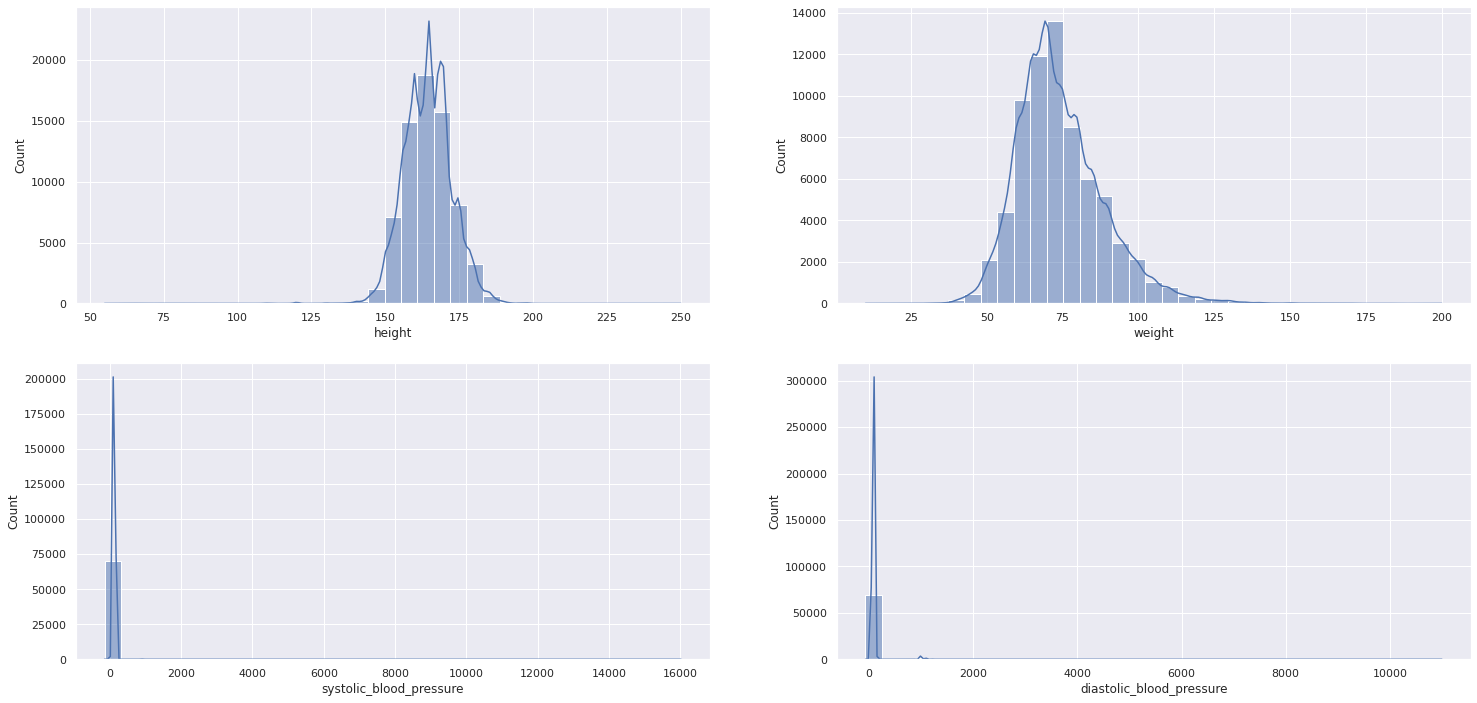

In [34]:
plt.subplot(2, 2, 1)
sns.histplot(x="height", kde=True, bins=35, data=num_attr);

plt.subplot(2, 2, 2)
sns.histplot(x="weight", kde=True, bins=35, data=num_attr);

plt.subplot(2, 2, 3)
sns.histplot(x="systolic_blood_pressure", kde=True, bins=35, data=num_attr);

plt.subplot(2, 2, 4)
sns.histplot(x="diastolic_blood_pressure", kde=True, bins=35, data=num_attr);


### 1.5.2 Categorical Attributes

In [35]:
cat_attr.apply(lambda i: i.unique().shape[0])

cholesterol          3
gender               2
glucose              3
smoking              2
alcohol              2
physical_activity    2
disease              2
dtype: int64

In [36]:
cat_attr.value_counts().reset_index().rename(columns={0: "counts"})

cholesterol gender            glucose smoking alcohol physical_activity disease  counts
0               normal  women             normal      No      No               Yes      No   14027
1               normal  women             normal      No      No               Yes     Yes   10206
2               normal    men             normal      No      No               Yes      No    5840
3               normal    men             normal      No      No               Yes     Yes    4672
4               normal  women             normal      No      No                No      No    3205
5               normal  women             normal      No      No                No     Yes    2802
6         above normal  women             normal      No      No               Yes     Yes    1977
7    well above normal  women             normal      No      No               Yes     Yes    1796
8               normal    men             normal      No      No                No     Yes    1445
9         above normal  women             normal      No      No               Yes      No    1410
10              normal    men             normal      No      No                No      No    1345
11   well above normal  women  well above normal      No      No               Yes     Yes    1270
12              normal    men             normal     Yes      No               Yes      No    1264
13              normal    men             normal     Yes      No               Yes     Yes     830
14        above normal    men             normal      No      No               Yes     Yes     742
15        above normal  women       above normal      No      No               Yes     Yes     677
16              normal    men             normal     Yes     Yes               Yes      No     634
17   well above normal    men             normal      No      No               Yes     Yes     629
18   well above normal  women  well above normal      No      No               Yes      No     557
19              normal  women       above normal      No      No               Yes     Yes     540
20        above normal  women       above normal      No      No               Yes      No     526
21        above normal  women             normal      No      No                No     Yes     525
22              normal  women       above normal      No      No               Yes      No     495
23   well above normal    men  well above normal      No      No               Yes     Yes     435
24        above normal    men             normal      No      No               Yes      No     424
25              normal  women  well above normal      No      No               Yes      No     393
26   well above normal  women             normal      No      No               Yes      No     362
27   well above normal  women  well above normal      No      No                No     Yes     358
28   well above normal  women             normal      No      No                No     Yes     345
29              normal  women  well above normal      No      No               Yes     Yes     342
30              normal    men             normal     Yes     Yes               Yes     Yes     326
31        above normal  women             normal      No      No                No      No     318
32        above normal    men       above normal      No      No               Yes     Yes     270
33              normal    men             normal      No     Yes               Yes      No     259
34              normal    men       above normal      No      No               Yes     Yes     249
35              normal  women             normal      No     Yes               Yes      No     248
36        above normal    men             normal      No      No                No     Yes     234
37        above normal  women       above normal      No      No                No     Yes     222
38   well above normal  women       above normal      No      No               Yes     Yes     214
39        above normal    men             normal   

# 2.0 Feature Engineering

In [37]:
df2 = df1.copy()

## 2.1 Mind Map

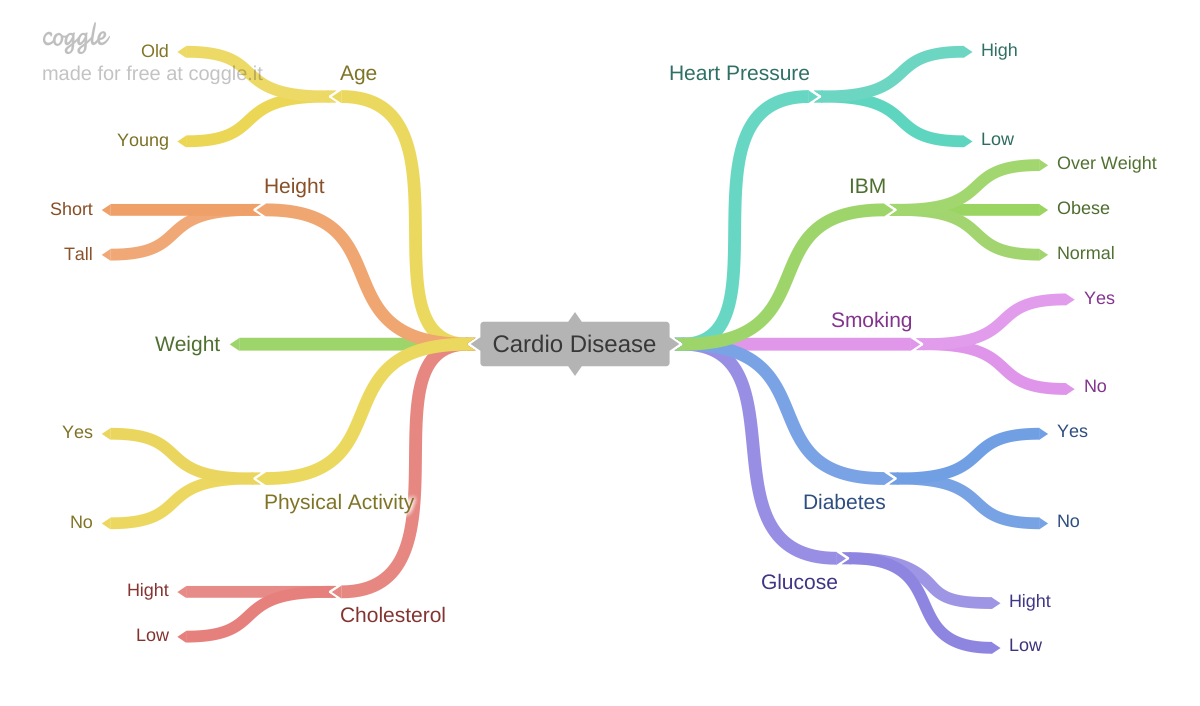

In [40]:
Image("../images/mindmap.png")

## 2.2 Creating Hypothesis

1. The older a person is, the more likely they are to be sick.
1. Who smokes has more the chance to be sick.
1. Who doesn't make physical activity may be sick.
1. The more obese a person is, the more chance of being sick.
1. High cholesterol means that the person may have heart problems.

## 2.3 Feature Engineering

In [38]:
df2["age_year"] = df2["age"].apply(lambda i: np.int(np.round(i / 365)))
df2["life_stage"] = df2["age_year"].apply(getLifeStage)

In [39]:
df2["IBM"] = df2[["height", "weight"]].apply(lambda i: calcIBM(i["weight"], i["height"]/100), axis=1)
df2["weight_status"] = df2["IBM"].apply(catIBM)

# 3.0 Filtering Variables

In [41]:
df3 = df2.copy()

## 3.1 Filtering Lines

Seeing systolic and dystolic blood pressure there's some outliers. I'll use [Understanding Blood Pressure Readings](https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings) as a reference to select some lines.

In [42]:
df3 = df3[(df3["systolic_blood_pressure"] < 300) & (df3["systolic_blood_pressure"] > 0)]
df3 = df3[(df3["diastolic_blood_pressure"] < 300) & (df3["diastolic_blood_pressure"] > 0)]

In [43]:
df3 = df3.drop_duplicates()

## 3.2 Filtering Columns

I will drop the column "age" because I've created the column "age_year" as a alternative.

In [44]:
df3 = df3.drop(columns=["age"], axis=1)

# 4.0 Exploratory Data Analysis

In [45]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

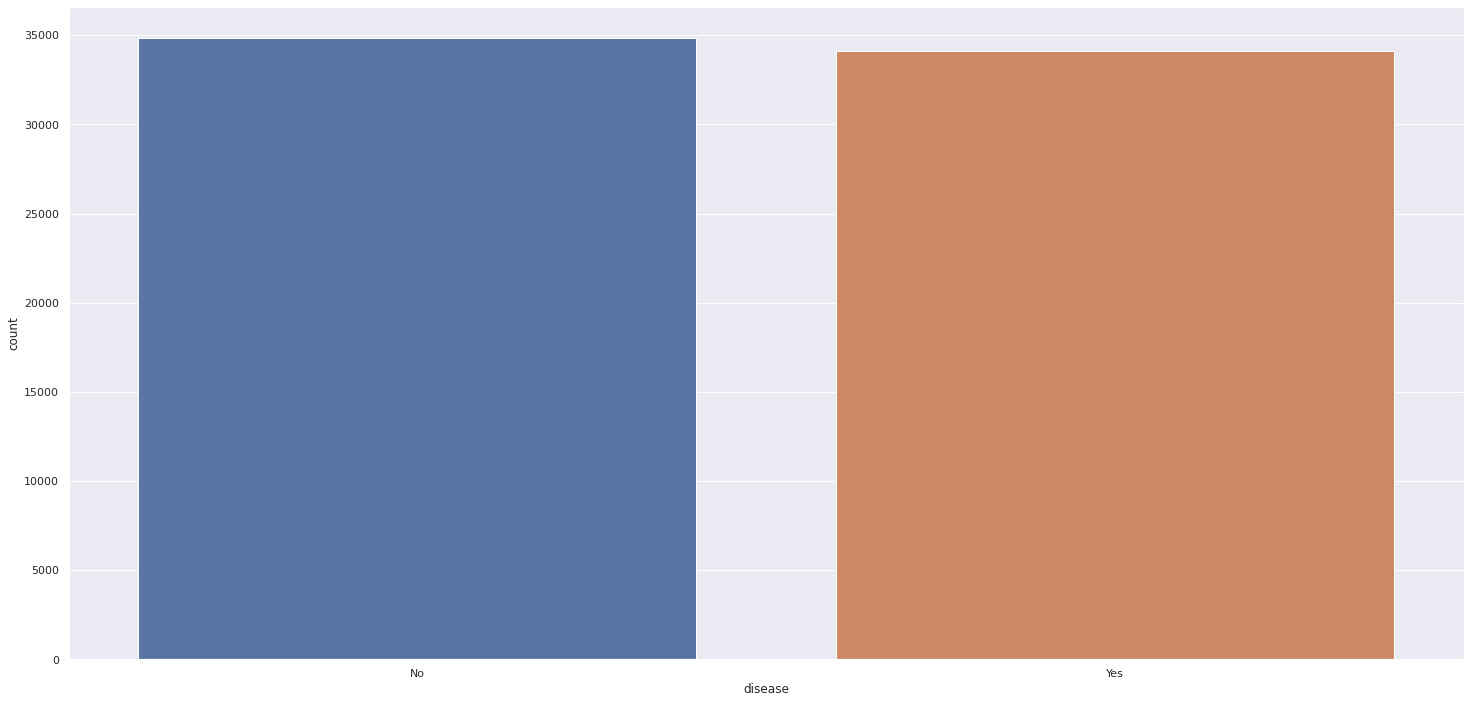

In [46]:
sns.countplot(x="disease", data=df4);

### 4.1.2 Numerical Variable

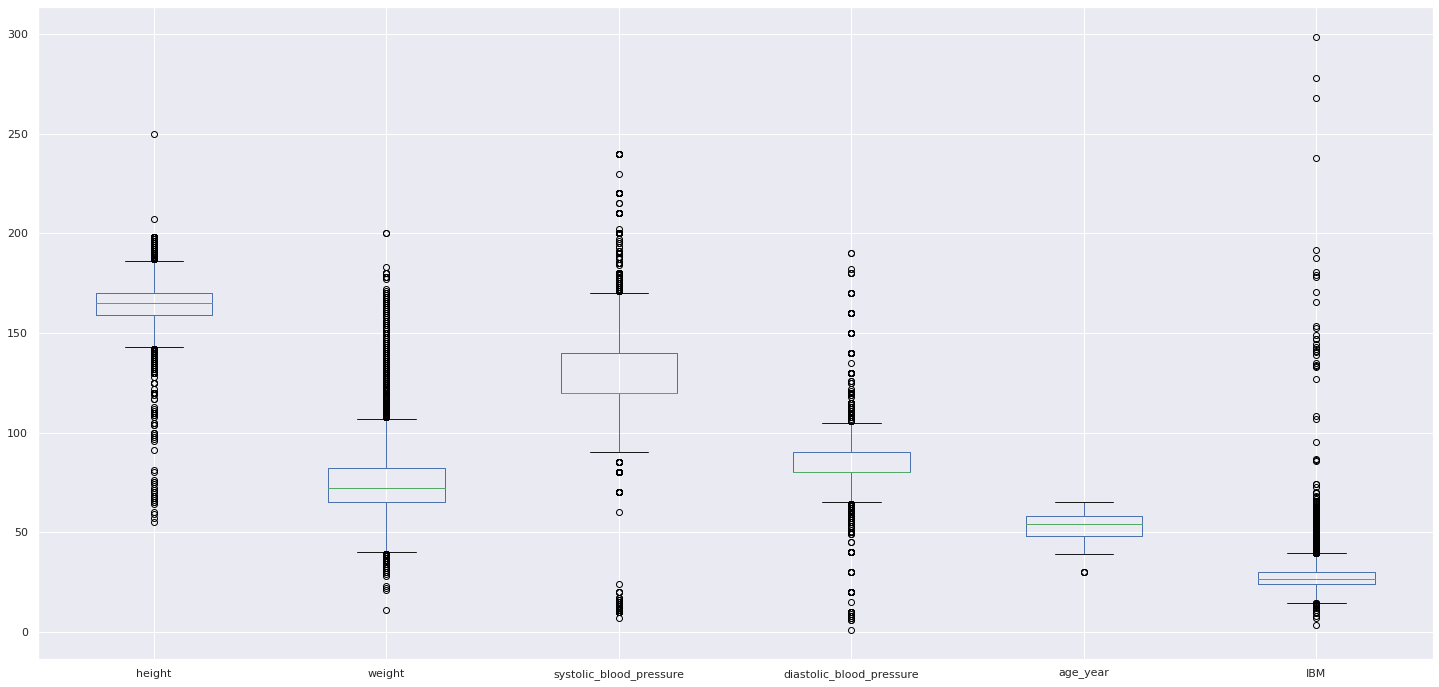

In [47]:
ax1 = df4.select_dtypes(exclude=["object"]).drop(columns=["id"], axis=1)
ax1.plot.box();

### 4.1.3 Categorical Variables

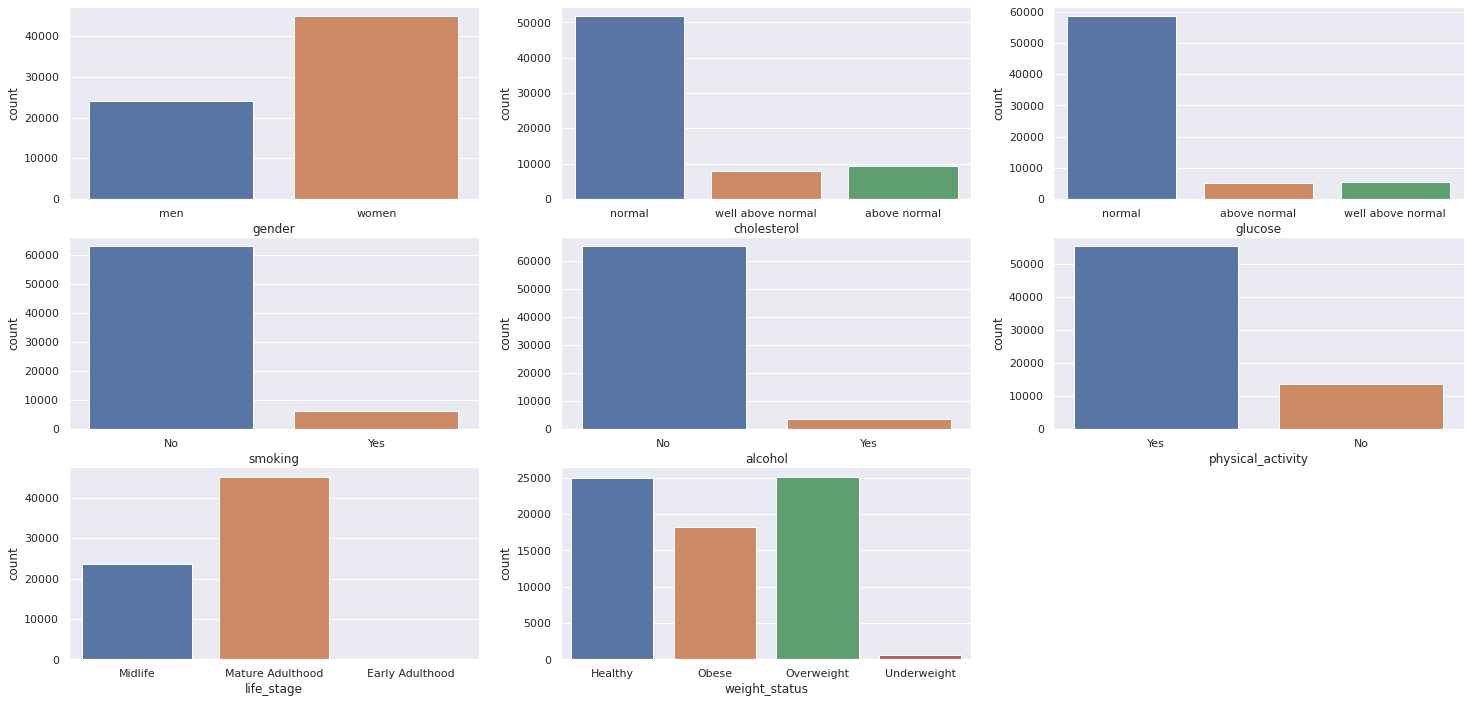

In [48]:
aux1 = df4.select_dtypes(include="object")

plt.subplot(3, 3, 1)
sns.countplot(x="gender", data=aux1);

plt.subplot(3, 3, 2)
sns.countplot(x="cholesterol", data=aux1);

plt.subplot(3, 3, 3)
sns.countplot(x="glucose", data=aux1);

plt.subplot(3, 3, 4)
sns.countplot(x="smoking", data=aux1);

plt.subplot(3, 3, 5)
sns.countplot(x="alcohol", data=aux1);

plt.subplot(3, 3, 6)
sns.countplot(x="physical_activity", data=aux1);

plt.subplot(3, 3, 7)
sns.countplot(x="life_stage", data=aux1);

plt.subplot(3, 3, 8)
sns.countplot(x="weight_status", data=aux1);

## 4.2 Bivariate Analysis

### H1 The older a person is, the more likely they are to be sick.
**TRUE** The older the pearson is the probability to be sick is higher.

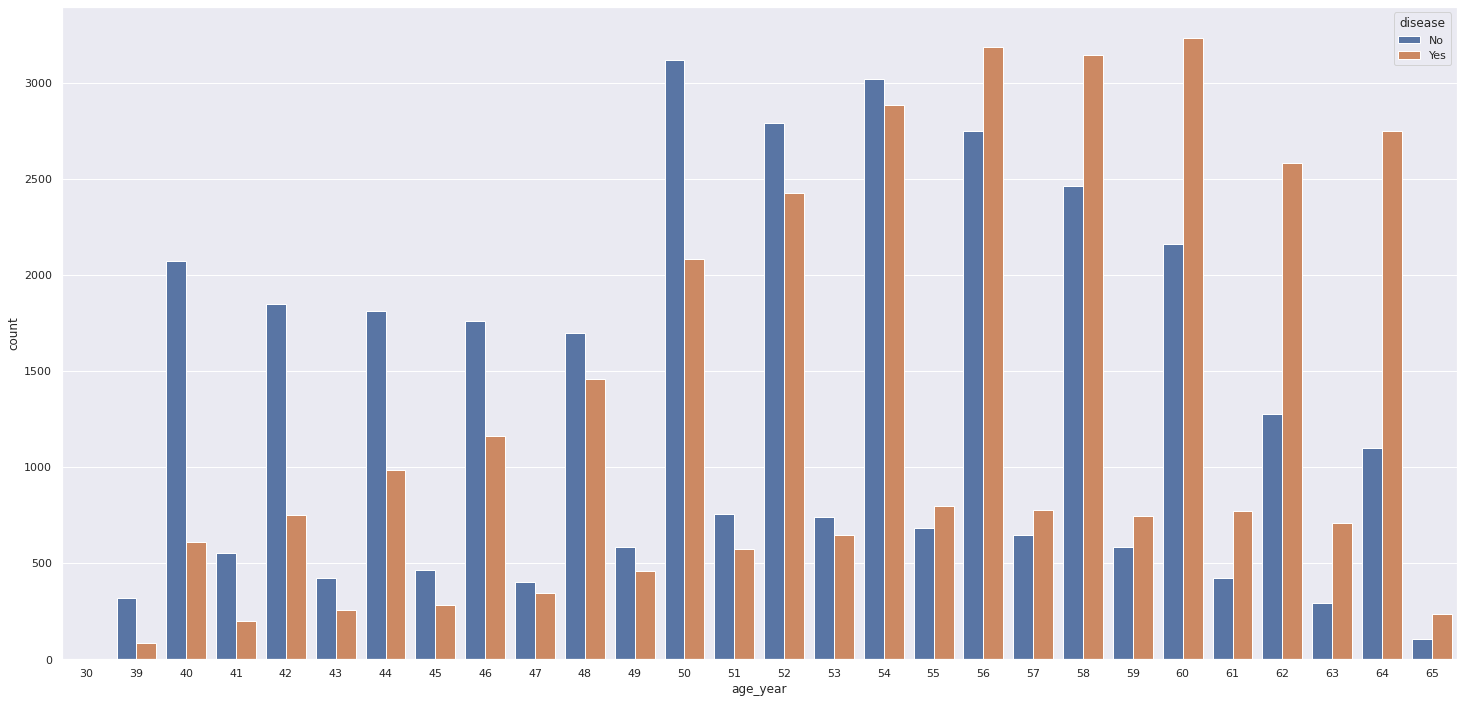

In [49]:
sns.countplot(x="age_year", data=df4, hue="disease");

### H2 Who smokes has more the chance to be sick.

**FALSE** If they smoke it doesn't mean they're dicease.

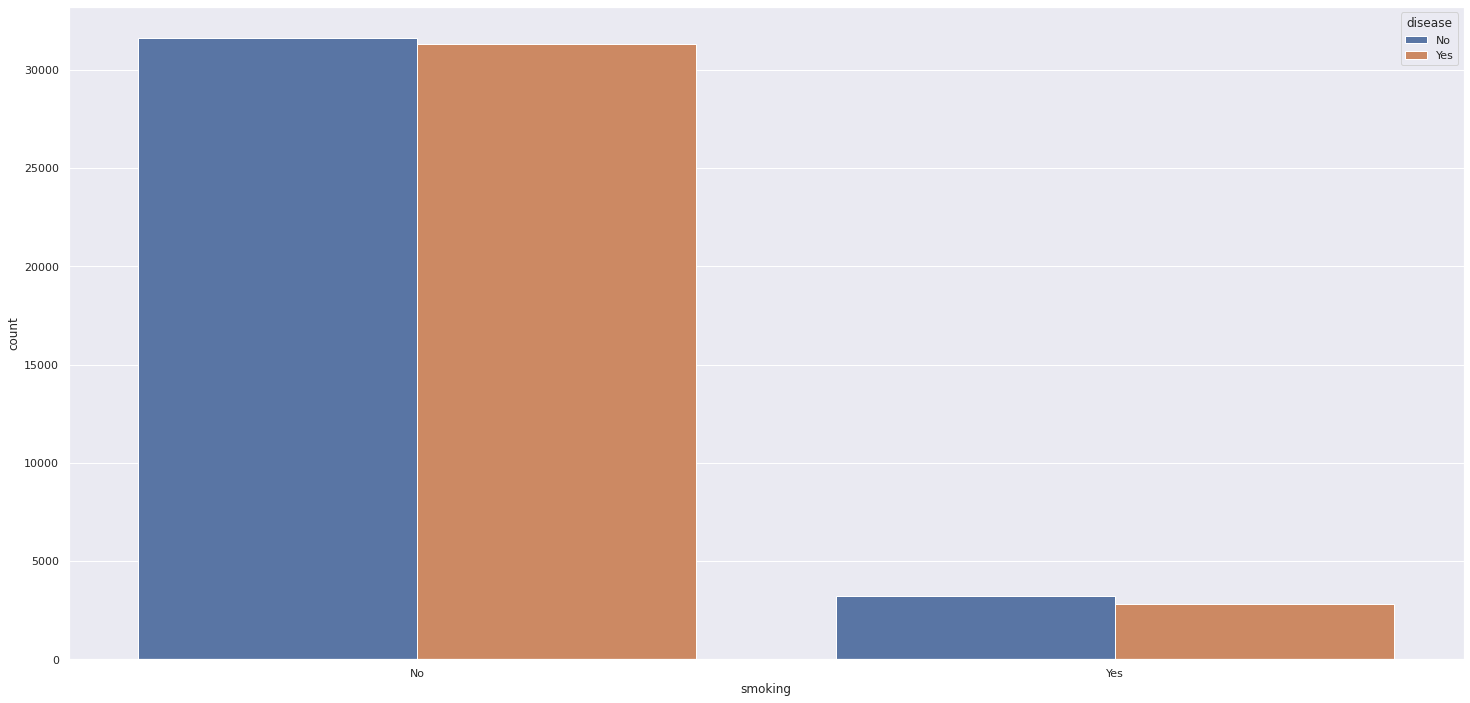

In [50]:
sns.countplot(x="smoking", data=df4, hue="disease");

### H3 Who doesn't make physical activity may be sick.

**TRUE** There's more sick peaple which doesn't make physical activity.

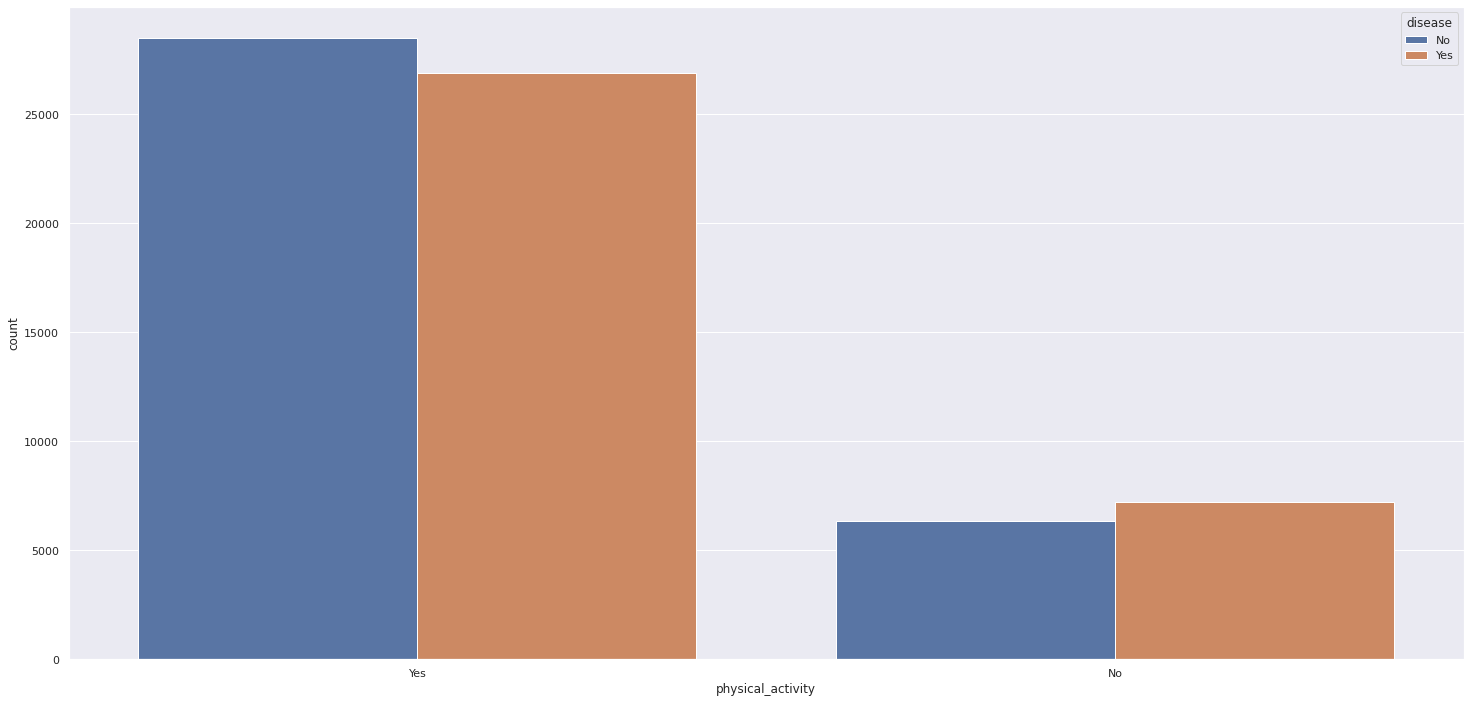

In [51]:
sns.countplot(x="physical_activity", data=df4, hue="disease");

### H4 The more obese a person is, the more chance of being sick.

**TRUE** There's more sick peaple whom weight status is obese and overweight

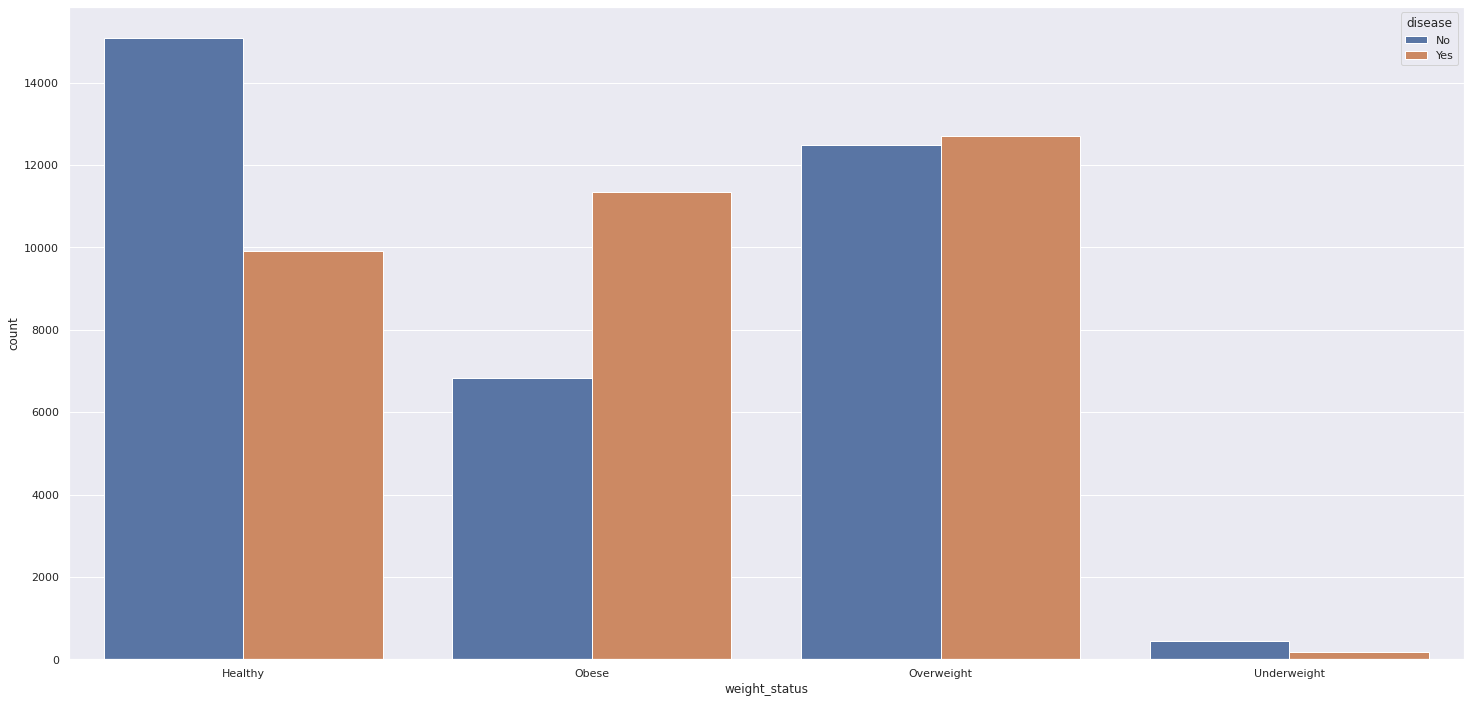

In [52]:
sns.countplot(x="weight_status", data=df4, hue="disease");

### H5 High cholesterol means that the person may have heart problems.

**TRUE** There's more sick peaple who has the cholesterol above and well above normal.

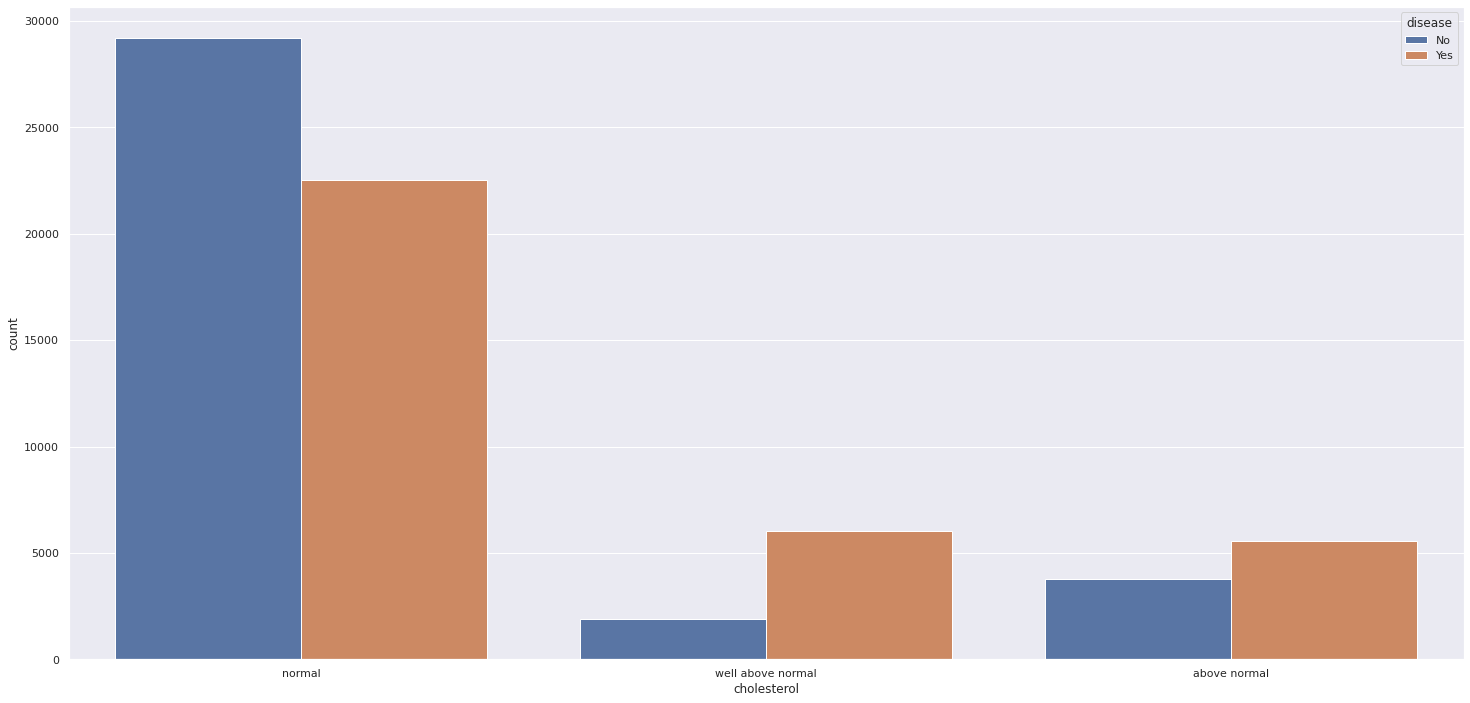

In [53]:
sns.countplot(x="cholesterol", data=df4, hue="disease");

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

In [54]:
aux1 = df4.select_dtypes(exclude="object").drop("id", axis=1)
corr = aux1.corr()

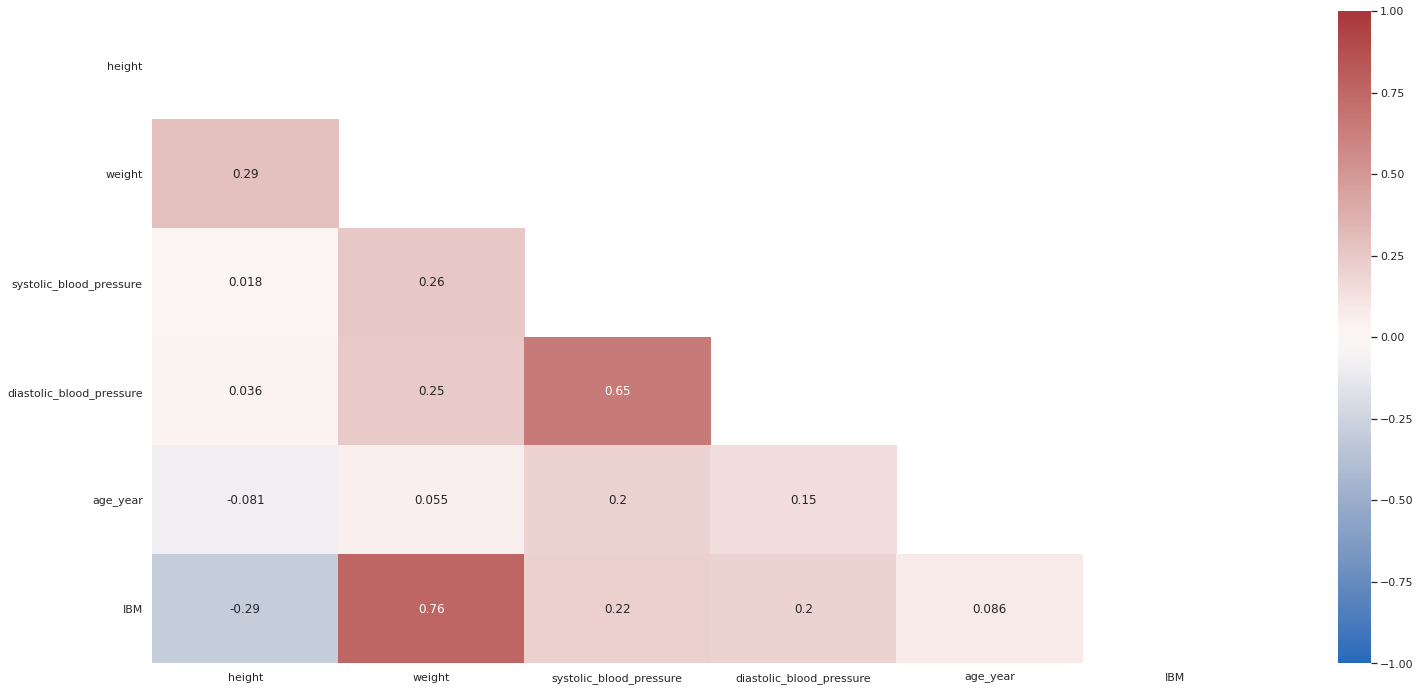

In [55]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots()
    ax = sns.heatmap(corr, annot=True, vmax=1, vmin=-1, mask=mask, center=0, cmap="vlag");

### 4.3.2 Categorical Atributes

In [56]:
aux1 = df4.select_dtypes(include="object")

In [57]:
c1 = calcCramerV(aux1.gender, aux1.gender)
c2 = calcCramerV(aux1.gender, aux1.cholesterol)
c3 = calcCramerV(aux1.gender, aux1.glucose)
c4 = calcCramerV(aux1.gender, aux1.smoking)
c5 = calcCramerV(aux1.gender, aux1.alcohol)
c6 = calcCramerV(aux1.gender, aux1.physical_activity)
c7 = calcCramerV(aux1.gender, aux1.disease)
c8 = calcCramerV(aux1.gender, aux1.life_stage)
c9 = calcCramerV(aux1.gender, aux1.weight_status)

c10 = calcCramerV(aux1.cholesterol, aux1.gender)
c11 = calcCramerV(aux1.cholesterol, aux1.cholesterol)
c12 = calcCramerV(aux1.cholesterol, aux1.glucose)
c13 = calcCramerV(aux1.cholesterol, aux1.smoking)
c14 = calcCramerV(aux1.cholesterol, aux1.alcohol)
c15 = calcCramerV(aux1.cholesterol, aux1.physical_activity)
c16 = calcCramerV(aux1.cholesterol, aux1.disease)
c17 = calcCramerV(aux1.cholesterol, aux1.life_stage)
c18 = calcCramerV(aux1.cholesterol, aux1.weight_status)

c19 = calcCramerV(aux1.glucose, aux1.gender)
c20 = calcCramerV(aux1.glucose, aux1.cholesterol)
c21 = calcCramerV(aux1.glucose, aux1.glucose)
c22 = calcCramerV(aux1.glucose, aux1.smoking)
c23 = calcCramerV(aux1.glucose, aux1.alcohol)
c24 = calcCramerV(aux1.glucose, aux1.physical_activity)
c25 = calcCramerV(aux1.glucose, aux1.disease)
c26 = calcCramerV(aux1.glucose, aux1.life_stage)
c27 = calcCramerV(aux1.glucose, aux1.weight_status)

c28 = calcCramerV(aux1.smoking, aux1.gender)
c29 = calcCramerV(aux1.smoking, aux1.cholesterol)
c30 = calcCramerV(aux1.smoking, aux1.glucose)
c31 = calcCramerV(aux1.smoking, aux1.smoking)
c32 = calcCramerV(aux1.smoking, aux1.alcohol)
c33 = calcCramerV(aux1.smoking, aux1.physical_activity)
c34 = calcCramerV(aux1.smoking, aux1.disease)
c35 = calcCramerV(aux1.smoking, aux1.life_stage)
c36 = calcCramerV(aux1.smoking, aux1.weight_status)

c37 = calcCramerV(aux1.alcohol, aux1.gender)
c38 = calcCramerV(aux1.alcohol, aux1.cholesterol)
c39 = calcCramerV(aux1.alcohol, aux1.glucose)
c40 = calcCramerV(aux1.alcohol, aux1.smoking)
c41 = calcCramerV(aux1.alcohol, aux1.alcohol)
c42 = calcCramerV(aux1.alcohol, aux1.physical_activity)
c43 = calcCramerV(aux1.alcohol, aux1.disease)
c44 = calcCramerV(aux1.alcohol, aux1.life_stage)
c45 = calcCramerV(aux1.alcohol, aux1.weight_status)

c46 = calcCramerV(aux1.physical_activity, aux1.gender)
c47 = calcCramerV(aux1.physical_activity, aux1.cholesterol)
c48 = calcCramerV(aux1.physical_activity, aux1.glucose)
c49 = calcCramerV(aux1.physical_activity, aux1.smoking)
c50 = calcCramerV(aux1.physical_activity, aux1.alcohol)
c51 = calcCramerV(aux1.physical_activity, aux1.physical_activity)
c52 = calcCramerV(aux1.physical_activity, aux1.disease)
c53 = calcCramerV(aux1.physical_activity, aux1.life_stage)
c54 = calcCramerV(aux1.physical_activity, aux1.weight_status)

c55 = calcCramerV(aux1.disease, aux1.gender)
c56 = calcCramerV(aux1.disease, aux1.cholesterol)
c57 = calcCramerV(aux1.disease, aux1.glucose)
c58 = calcCramerV(aux1.disease, aux1.smoking)
c59 = calcCramerV(aux1.disease, aux1.alcohol)
c60 = calcCramerV(aux1.disease, aux1.physical_activity)
c61 = calcCramerV(aux1.disease, aux1.disease)
c62 = calcCramerV(aux1.disease, aux1.life_stage)
c63 = calcCramerV(aux1.disease, aux1.weight_status)

c64 = calcCramerV(aux1.life_stage, aux1.gender)
c65 = calcCramerV(aux1.life_stage, aux1.cholesterol)
c66 = calcCramerV(aux1.life_stage, aux1.glucose)
c67 = calcCramerV(aux1.life_stage, aux1.smoking)
c68 = calcCramerV(aux1.life_stage, aux1.alcohol)
c69 = calcCramerV(aux1.life_stage, aux1.physical_activity)
c70 = calcCramerV(aux1.life_stage, aux1.disease)
c71 = calcCramerV(aux1.life_stage, aux1.life_stage)
c72 = calcCramerV(aux1.life_stage, aux1.weight_status)

c73 = calcCramerV(aux1.weight_status, aux1.gender)
c74 = calcCramerV(aux1.weight_status, aux1.cholesterol)
c75 = calcCramerV(aux1.weight_status, aux1.glucose)
c76 = calcCramerV(aux1.weight_status, aux1.smoking)
c77 = calcCramerV(aux1.weight_status, aux1.alcohol)
c78 = calcCramerV(aux1.weight_status, aux1.physical_activity)
c79 = calcCramerV(aux1.weight_status, aux1.disease)
c80 = calcCramerV(aux1.weight_status, aux1.life_stage)
c81 = calcCramerV(aux1.weight_status, aux1.weight_status)

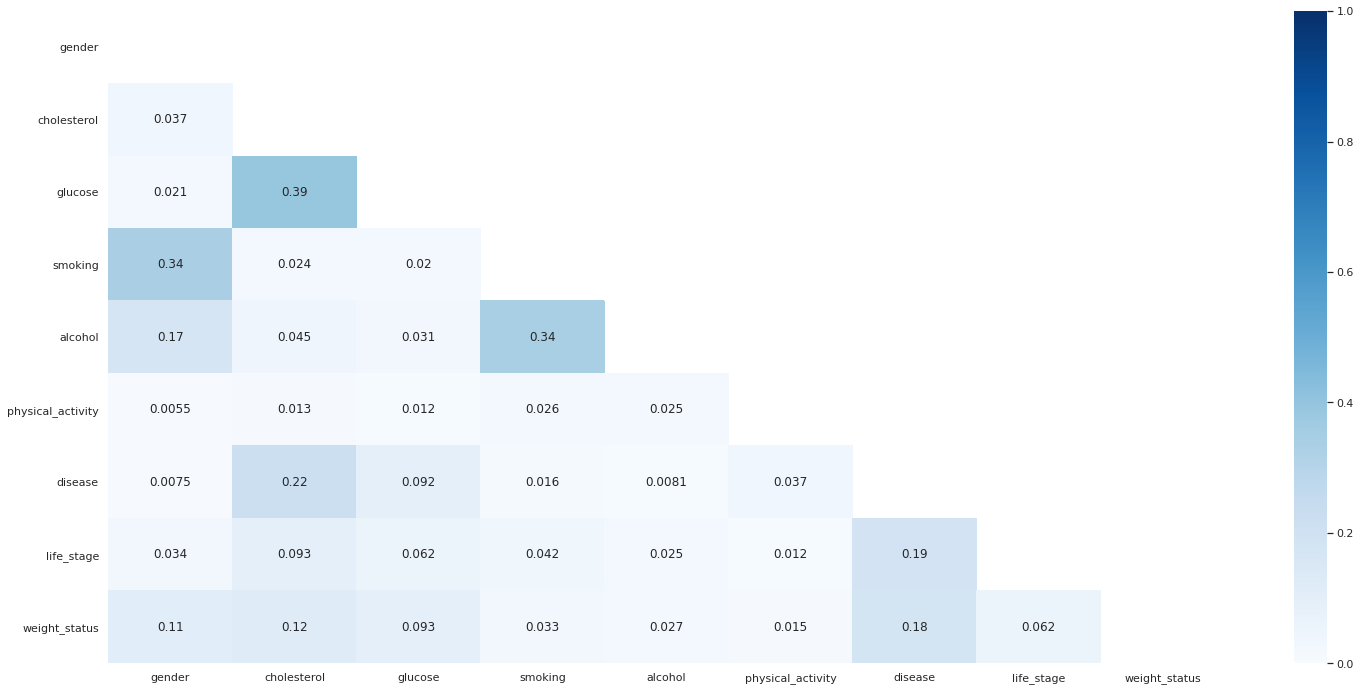

In [58]:
cramerv = pd.DataFrame({
    "gender": [c1, c2, c3, c4, c5, c6, c7, c8, c9], 
    "cholesterol": [c10, c11, c12, c13, c14, c15, c16, c17, c18], 
    "glucose": [c19, c20, c21, c22, c23, c24, c25, c26, c27],
    "smoking": [c28, c29, c30, c31, c32, c33, c34, c35, c36],
    "alcohol": [c37, c38, c39, c40, c41, c42, c43, c44, c45],
    "physical_activity": [c46, c47, c48, c49, c50, c51, c52, c53, c54],
    "disease": [c55, c56, c57, c58, c59, c60, c61, c62, c63],
    "life_stage": [c64, c65, c66, c67, c68, c69, c70, c71, c72],
    "weight_status": [c73, c74, c75, c76, c77, c78, c79, c80, c81]
                  })

cramerv = cramerv.set_index(cramerv.columns)

mask = np.zeros_like(cramerv)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots()
    ax = sns.heatmap(cramerv, annot=True, vmin=0, vmax=1, mask=mask, cmap="Blues")

# 5.0 Data Preparation

In [59]:
df5 = df4.copy()

## 5.1 Enconding

In [60]:
df5["cholesterol"] = df5["cholesterol"].map({"normal": 0, "above normal": 1, "well above normal": 2})
df5["glucose"] = df5["glucose"].map({"normal": 0, "above normal": 1, "well above normal": 2})
df5["weight_status"] = df5["weight_status"].map({"Underweight": 0, "Healthy": 1, "Obese": 2, "Overweight": 3})

## 5.2 OneHot Enconding

This step will increase the data dimension, however later I'll apply a algorithm to select the best columns for model training and prediction. It'll deacrease the data dimension and improve the model score.

In [61]:
df5["disease"] = df5["disease"].map({"Yes": 1, "No": 0})

In [62]:
ohe_columns = ["gender", "smoking", "alcohol", "physical_activity", "life_stage"]
df5 = pd.get_dummies(df5, columns=ohe_columns, drop_first=True)

## 5.2 Spliting into Test and Train DataFrame

In [63]:
X = df5.drop(columns=["id", "disease"], axis=1)
y = df5["disease"]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

## 5.3 Rescaling

Rescaling it's important to make the prediction faster and each feature contributes equally for model learning. However, there are a lot of outliers, so in this PRISM step I'll use robust scaler. For another cicle step I can try to treat the outliers.

In [65]:
X_rescaled = X.copy()

rbs = RobustScaler()
X_rescaled[["height", "weight", "systolic_blood_pressure", "diastolic_blood_pressure", "age_year", "IBM"]] = rbs.fit_transform(X[["height", "weight", "systolic_blood_pressure", "diastolic_blood_pressure", "age_year", "IBM"]])

In [66]:
X_train_rescaled = X_train.copy()
X_test_rescaled = X_test.copy()

X_train_rescaled[["height", "weight", "systolic_blood_pressure", "diastolic_blood_pressure", "age_year", "IBM"]] = rbs.fit_transform(X_train[["height", "weight", "systolic_blood_pressure", "diastolic_blood_pressure", "age_year", "IBM"]])
X_test_rescaled[["height", "weight", "systolic_blood_pressure", "diastolic_blood_pressure", "age_year", "IBM"]] = rbs.fit_transform(X_test[["height", "weight", "systolic_blood_pressure", "diastolic_blood_pressure", "age_year", "IBM"]])

# 6.0 Feature Selection

## 6.1 Random Forest as Feature Selector

In [67]:
#rf = RandomForestClassifier(n_estimators=3000, n_jobs=-1)

#sfm = SelectFromModel(estimator=rf)
#sfm.fit(X_train_rescaled, y_train)

### 6.2.1 Best Selected Columns

In [68]:
#best_columns = sfm.get_support()
#best_columns_rf = X_test.loc[:, best_columns].columns.to_list()

In [69]:
best_columns_rf = ['height', 'weight', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'age_year', 'IBM']

# 7.0 Machine Learning Modeling

## 7.1 Baseline Model

In [73]:
dummy = DummyClassifier(strategy="prior")
dummy.fit(X_train_rescaled[best_columns_rf], y_train)

DummyClassifier(strategy='prior')

In [74]:
y_pred = dummy.predict(X_test_rescaled[best_columns_rf])

dummy_resul = ml_scores("Dummy", y_test, y_pred)
dummy_resul

/home/junior/.pyenv/versions/anaconda3-2020.02/envs/ds/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy  Precision  Recall   F1
Dummy     0.505        0.0     0.0  0.0

### 7.1.1 Base Line Model - Cross Validation

In [75]:
dummy_cv = ml_cv_results("Dummy", DummyClassifier(), RobustScaler(), X[best_columns_rf], y)
dummy_cv

/home/junior/.pyenv/versions/anaconda3-2020.02/envs/ds/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/home/junior/.pyenv/versions/anaconda3-2020.02/envs/ds/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/home/junior/.pyenv/versions/anaconda3-2020.02/envs/ds/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/home/junior/.pyenv/versions/anaconda3-2020.02/envs/ds/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("T

Accuracy       Precision          Recall              F1
Dummy  0.501 +/- 0.006  0.501 +- 0.006  0.501 +- 0.006  0.501 +- 0.006

## 7.2 Logistic Regression

In [76]:
lg = LogisticRegression()
lg.fit(X_train_rescaled[best_columns_rf], y_train)

y_pred = lg.predict(X_test_rescaled[best_columns_rf])

In [77]:
lg_resul = ml_scores("Logistic Regression", y_test, y_pred)
lg_resul

Accuracy  Precision  Recall     F1
Logistic Regression     0.717      0.737   0.664  0.699

### 7.2.1 Logistic Regression - Cross Validation

In [78]:
lg_cv = ml_cv_results("Logistic Regression", LogisticRegression(), RobustScaler(), X[best_columns_rf], y)
lg_cv

Accuracy       Precision          Recall              F1
Logistic Regression  0.717 +/- 0.003  0.719 +- 0.003  0.717 +- 0.003  0.716 +- 0.003

## 7.3 K Nearest Neighbors

In [81]:
knn = KNeighborsClassifier()
knn.fit(X_train_rescaled[best_columns_rf], y_train)

y_pred = knn.predict(X_test_rescaled[best_columns_rf])

In [82]:
knn_resul = ml_scores("KNN", y_test, y_pred)
knn_resul

Accuracy  Precision  Recall    F1
KNN     0.679      0.681   0.659  0.67

### 7.3.1 Support Vector Machine - Cross Validation

In [83]:
knn_cv = ml_cv_results("KNN", KNeighborsClassifier(), RobustScaler(), X[best_columns_rf], y)
knn_cv

Accuracy       Precision          Recall              F1
KNN  0.681 +/- 0.002  0.681 +- 0.002  0.681 +- 0.002  0.681 +- 0.002

## 7.4 Random Forest

In [84]:
rf = RandomForestClassifier()
rf.fit(X_train_rescaled[best_columns_rf], y_train)

y_pred = rf.predict(X_test_rescaled[best_columns_rf])

In [85]:
rf_resul = ml_scores("Random Forest", y_test, y_pred)
rf_resul

Accuracy  Precision  Recall     F1
Random Forest     0.683      0.686   0.661  0.674

### 7.4.1 Random Forest - Cross Validation

In [86]:
rf_cv = ml_cv_results("Random Forest", RandomForestClassifier(), RobustScaler(), X[best_columns_rf], y)
rf_cv

Accuracy       Precision          Recall              F1
Random Forest  0.683 +/- 0.004  0.683 +- 0.004  0.682 +- 0.004  0.682 +- 0.004

## 7.5 XGBoost Classifier

In [87]:
xgb = XGBClassifier()
xgb.fit(X_train_rescaled[best_columns_rf], y_train)

y_pred = xgb.predict(X_test_rescaled[best_columns_rf])

In [88]:
xgb_resul = ml_scores("XGBoost", y_test, y_pred)
xgb_resul

Accuracy  Precision  Recall     F1
XGBoost     0.717      0.737   0.665  0.699

### 7.5.1 XGBoost Classifier - Cross Validation

In [89]:
xgb_cv = ml_cv_results("XGBoost", XGBClassifier(), RobustScaler(), X[best_columns_rf], y)
xgb_cv

Accuracy       Precision          Recall              F1
XGBoost  0.72 +/- 0.003  0.721 +- 0.003  0.719 +- 0.003  0.719 +- 0.003

## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [91]:
modeling_performance = pd.concat([dummy_resul, lg_resul, knn_resul, rf_resul, xgb_resul])
modeling_performance.sort_values(by="Recall", ascending=True)

Accuracy  Precision  Recall     F1
Dummy                   0.505      0.000   0.000  0.000
KNN                     0.679      0.681   0.659  0.670
Random Forest           0.683      0.686   0.661  0.674
Logistic Regression     0.717      0.737   0.664  0.699
XGBoost                 0.717      0.737   0.665  0.699

### 7.6.2 Cross Validation Performance

In [92]:
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, knn_cv, rf_cv, xgb_cv])
modeling_performance_cv.sort_values(by="Recall", ascending=True)

Accuracy       Precision          Recall              F1
Dummy                0.501 +/- 0.006  0.501 +- 0.006  0.501 +- 0.006  0.501 +- 0.006
KNN                  0.681 +/- 0.002  0.681 +- 0.002  0.681 +- 0.002  0.681 +- 0.002
Random Forest        0.683 +/- 0.004  0.683 +- 0.004  0.682 +- 0.004  0.682 +- 0.004
Logistic Regression  0.717 +/- 0.003  0.719 +- 0.003  0.717 +- 0.003  0.716 +- 0.003
XGBoost               0.72 +/- 0.003  0.721 +- 0.003  0.719 +- 0.003  0.719 +- 0.003

I'll select Recall as a parameter for selection. Recall shows the relation between true positive and false negative. It's important for medicinal projects, which is important to reduce errors.

# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [93]:
#params = {
#    "learning_rate": np.arange(0.05,1.05, 0.05),
#    "n_estimators": [200, 500, 1000, 2000],
#    "subsample": np.arange(0.05,1.05, 0.05)
#}

#xgb = XGBClassifier()
#rscv = RandomizedSearchCV(estimator=xgb, param_distributions=params, n_iter=10, cv=5, verbose=10, scoring=recall, n_jobs=-1)

In [94]:
#rscv.fit(X, y)

In [95]:
best_params = {
    'subsample': 0.9000000000000001,
    'n_estimators': 200,
    'learning_rate': 0.6000000000000001
}

## 8.2 Final Model

In [96]:
xgb_best = XGBClassifier(subsample=best_params['subsample'], n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'])
xgb_best_cv = ml_cv_results("best XGBoosting", xgb_best, RobustScaler(), X[best_columns_rf], y)
xgb_best_cv

Accuracy       Precision        Recall            F1
best XGBoosting  0.701 +/- 0.004  0.702 +- 0.004  0.7 +- 0.004  0.7 +- 0.004

Selecting some parameters the model's score dicreased. So for this crisp step I'll use default XGBoostClassifier model.

# 9.0 Traduction and Error's Interpretation

## 9.1 Business Performance

In [97]:
xgb = XGBClassifier()
xgb.fit(X_train_rescaled[best_columns_rf], y_train)

y_pred = xgb.predict(X_test_rescaled[best_columns_rf])

In [98]:
xgb_resul = ml_scores("XGBoost", y_test, y_pred)
xgb_resul

Accuracy  Precision  Recall     F1
XGBoost     0.717      0.737   0.665  0.699

In [99]:
xgb_cv = ml_cv_results("XGBoost", XGBClassifier(), RobustScaler(), X[best_columns_rf], y)
xgb_cv

Accuracy       Precision         Recall              F1
XGBoost  0.72 +/- 0.003  0.722 +- 0.003  0.72 +- 0.003  0.719 +- 0.003

In [100]:
aux1 = pd.DataFrame(data={
        "Value": [0.720, 0.722, 0.720], 
        "Best Scenario": [0.720 + 0.003, 0.722 + 0.003, 0.720 + 0.003],
        "Worst Scenario": [0.720 - 0.003, 0.722 - 0.003, 0.720 - 0.003]
}, 
    index=["Accuracy", "Precision", "Recall"])

aux1

Value  Best Scenario  Worst Scenario
Accuracy   0.720          0.723           0.717
Precision  0.722          0.725           0.719
Recall     0.720          0.723           0.717

The model can have a accuracy of 72% for prediction so comparing with the earlier method it's better. Below there's a graph which shows the cost of the new and old prediction.

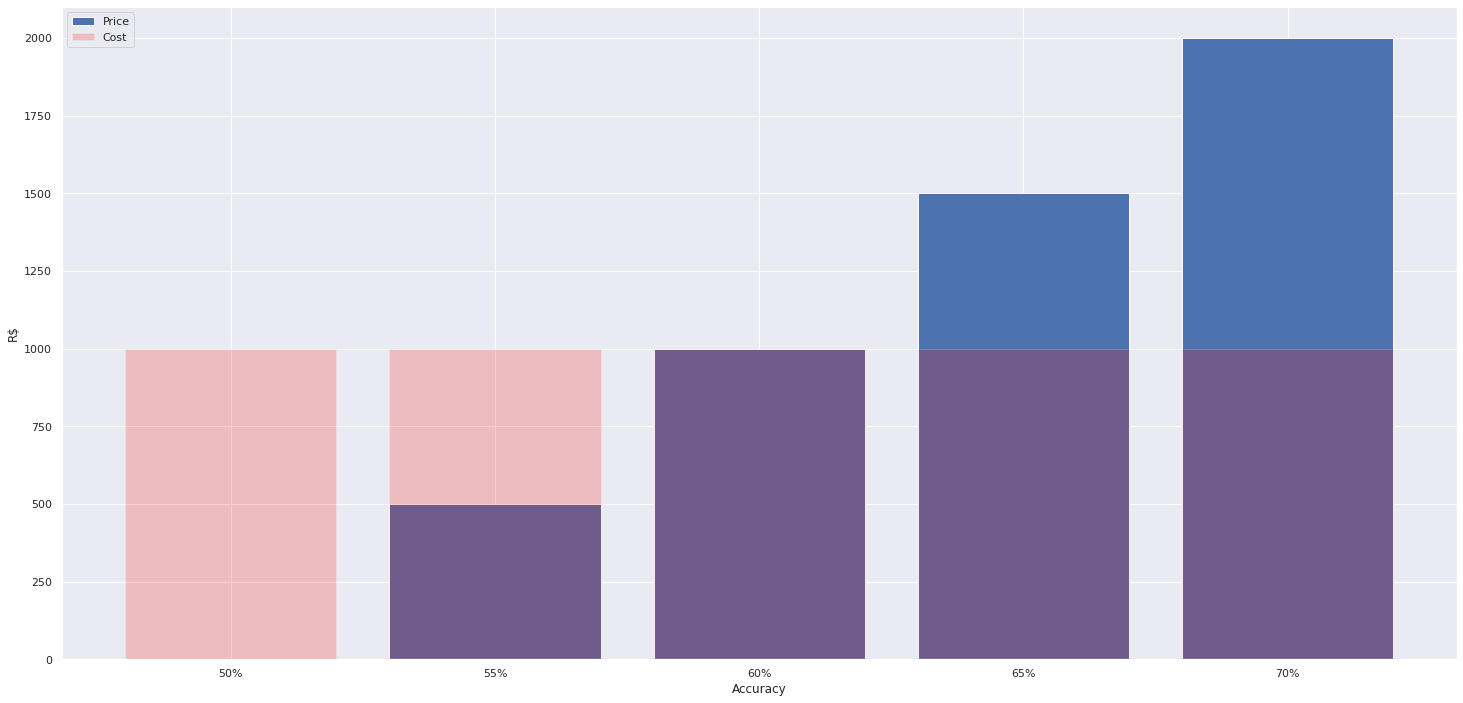

In [102]:
accuracy = ["50%", "55%", "60%", "65%", "70%"]
cost = [1000, 1000, 1000, 1000, 1000]
price = [0, 500, 1000, 1500, 2000]

plt.bar(x=accuracy, height=price, label="Price")
plt.bar(x=accuracy, height=cost, color="red", label="Cost", alpha=0.2)
plt.legend(loc="best")
plt.xlabel("Accuracy")
plt.ylabel("R$");

# 10.0 Deploy

In [113]:
# xgb = XGBClassifier()
# xgb.fit(X_rescaled[best_columns_rf], y)

# pickle.dump(xgb, open("../models/model_cardio.pkl", "wb"))

In [114]:
# rb = RobustScaler()
# rb.fit(X[best_columns_rf], y)

# pickle.dump(rb, open("../services/robust_scaler.pkl", "wb"))

## 10.1 Cardio Class

In [15]:
import pickle
import numpy as np
import pandas as pd

In [16]:
def getLifeStage(age):
    if age <= 3:
        life_stage = "Infancy"
    
    elif age > 3 and age <= 6:
        life_stage = "Early Childhood"
        
    elif age > 6 and age <= 8:
        life_stage = "Middle Childhood"
        
    elif age >= 9 and age <= 11:
        lige_stage = "Late Childhood"
        
    elif age >= 12 and age <= 20:
        life_stage = "Adolescence"
        
    elif age > 20 and age <= 35:
        life_stage = "Early Adulthood"
        
    elif age > 35 and age <= 50:
        life_stage = "Midlife"
        
    elif age > 50 and age <= 80:
        life_stage = "Mature Adulthood"
        
    else:
        life_stage = "Late Adulthood"
        
    return life_stage

def calcIBM(weight, height):
    #BMI = kg/m2
    ibm = np.round(weight / (height**2), 1)
    
    return ibm

def catIBM(ibm):
    if ibm < 18.5:
        status = "Underweight"
    
    elif ibm >= 18.5 and ibm <= 24.9:
        status = "Healthy"
    
    elif ibm >= 25.0 and ibm <= 29.9:
        status = "Overweight"
        
    elif ibm >= 30.0:
        status = "Obese"
        
    return status

In [3]:
class Cadio():
    
    def __init__(self):
        
        self.scaler = pickle.load(open("../services/robust_scaler.pkl", "rb"))
            
    def data_cleaning(self, df1):
        
        new_columns = {"ap_hi": "systolic_blood_pressure", "ap_lo": "diastolic_blood_pressure", "gluc": "glucose",
              "smoke": "smoking", "alco": "alcohol", "active": "physical_activity", "cardio": "disease"}
        df1.rename(columns=new_columns, inplace=True)
    
        df1 = df1[(df1["systolic_blood_pressure"] < 300) & (df1["systolic_blood_pressure"] > 0)]
        df1 = df1[(df1["diastolic_blood_pressure"] < 300) & (df1["diastolic_blood_pressure"] > 0)]

        df1 = df1.drop(columns=["age"], axis=1)
    
        return df1
    
    def feature_engineering(self, df2):
        
        df2["age_year"] = df2["age"].apply(lambda i: np.int(np.round(i / 365)))
        df2["life_stage"] = df2["age_year"].apply(getLifeStage)
        
        df2["IBM"] = df2[["height", "weight"]].apply(lambda i: calcIBM(i["weight"], i["height"]/100), axis=1)
        df2["weight_status"] = df2["IBM"].apply(catIBM)
        
        return df2
    
    def data_preparation(self, df3):
        
        #recaling
        df3[["height", "weight", "systolic_blood_pressure", "diastolic_blood_pressure", "age_year", "IBM"]] = scaler.transform(df3[["height", "weight", "systolic_blood_pressure", "diastolic_blood_pressure", "age_year", "IBM"]])
        
        #selected columns
        best_columns = ['height', 'weight', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'age_year', 'IBM']
        
        return df3[best_columns]
    
    def get_prediction(self, model, original_data, test_data):
        
        pred = model.predict(test_data)
        
        original_data["prediction"] = pred
        
        return original_data.to_json(orient="records", date_format="iso")

## 10.2 API Handler

In [18]:
import pickle
import pandas as pd
from flask import Flask, request, Response
#from cardio.Cardio import Cardio

model = pickle.load(open("../models/model_cardio.pkl", "rb"))
    
# loading
app = Flask(__name__)

@app.route("/cardio/predict", methods=['POST'])
def cardio_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instantiate Rossmann class
        pipeline = Cardio()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
        
    else:
        return Reponse("{}", status=200, mimetype="application/json")

if __name__ == '__main__':
    app.run( '0.0.0.0' )

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)


## 10.3 API Tester

In [34]:
# loading test dataset
df10 = pd.read_csv("../database/cardio_test.csv").iloc[0, :]

In [20]:
# merge test dataset + store
#df_test = pd.merge( df10, df_store_raw, how='left', on='Store')

In [36]:
# convert Dataframe to json
data = json.dumps(df10.to_dict())

In [38]:
# API Call
url = 'http://0.0.0.0:5000/cardio/predict'
#url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {"Content-type": "application/json"} 
data = data

r = requests.post(url, data=data)
print("Status Code {}".format(r.status_code))

NameError: name 'requests' is not defined

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [13]:
data

'[{"id": 96435, "age": 23372, "gender": 1, "height": 152, "weight": 72.0, "ap_hi": 140, "ap_lo": 80, "cholesterol": 3, "gluc": 1, "smoke": 0, "alco": 0, "active": 1, "cardio": 0}, {"id": 12815, "age": 21906, "gender": 1, "height": 160, "weight": 82.0, "ap_hi": 160, "ap_lo": 100, "cholesterol": 2, "gluc": 1, "smoke": 0, "alco": 0, "active": 1, "cardio": 1}, {"id": 93542, "age": 18242, "gender": 2, "height": 168, "weight": 76.0, "ap_hi": 120, "ap_lo": 80, "cholesterol": 1, "gluc": 1, "smoke": 0, "alco": 0, "active": 0, "cardio": 0}, {"id": 3597, "age": 16128, "gender": 1, "height": 158, "weight": 56.0, "ap_hi": 116, "ap_lo": 69, "cholesterol": 1, "gluc": 1, "smoke": 0, "alco": 0, "active": 1, "cardio": 0}, {"id": 24573, "age": 21961, "gender": 2, "height": 154, "weight": 58.0, "ap_hi": 100, "ap_lo": 70, "cholesterol": 1, "gluc": 1, "smoke": 0, "alco": 0, "active": 1, "cardio": 0}, {"id": 65805, "age": 21997, "gender": 1, "height": 163, "weight": 74.0, "ap_hi": 140, "ap_lo": 90, "choleste